# CNN classification

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [16]:
test_meta = pd.read_csv('/Users/yimi/Desktop/Courses/UC_Davis/2021spring/STA208/208Project/archive/test.txt', header=None, delimiter = " ")
train_meta = pd.read_csv('/Users/yimi/Desktop/Courses/UC_Davis/2021spring/STA208/208Project/archive/train_update.csv', sep = ",")

In [17]:
test_meta.columns = ['patient_id', 'filename', 'class', 'data source' ]

In [18]:
type(test_meta), type(train_meta)

(pandas.core.frame.DataFrame, pandas.core.frame.DataFrame)

In [19]:
train_meta.columns.values.tolist()

['Unnamed: 0', 'patient_id', 'filename', 'classes', 'data source']

In [20]:
train_meta = train_meta.drop(columns=['Unnamed: 0'])

In [21]:
train_meta.columns = ['patient_id', 'filename', 'classes', 'data source' ]
test_meta.columns = ['patient_id', 'filename', 'classes', 'data source' ]

In [22]:
train_meta.shape

(4316, 4)

In [23]:
test_meta.shape

(400, 4)

In [24]:
sum(train_meta['classes'] == 'positive'), sum(train_meta['classes'] == 'negative')

(2158, 2158)

In [30]:
train_path = '/Users/yimi/Desktop/Courses/UC_Davis/2021spring/STA208/208Project/archive/train/'
test_path = '/Users/yimi/Desktop/Courses/UC_Davis/2021spring/STA208/208Project/archive/test/'
img_height = 300
img_width = 300
batch_size = 32

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [32]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )

Found 4315 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


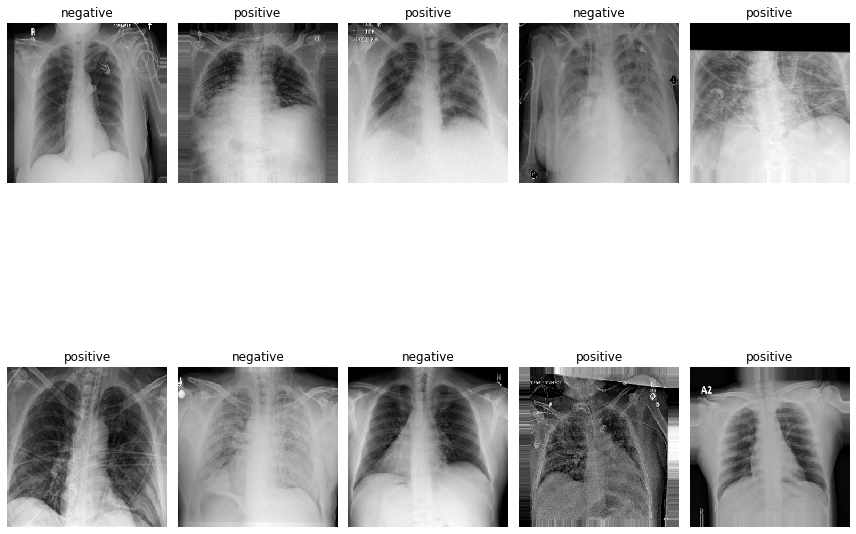

In [33]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'negative', 1:'positive'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
        
plt.tight_layout()
plt.show()

In [34]:
cnn = Sequential()

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))

cnn.add(Flatten())

# Dense
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))

#
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [35]:
# early = EarlyStopping(monitor= "val_loss", mode="min", patience=3)
early = EarlyStopping(mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(patience = 2, verbose=1, factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

In [36]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))

{0: 1.0002318034306907, 1: 0.9997683039851715}


In [37]:
cnn.fit(train,epochs=10, class_weight=cw, callbacks=callbacks_list)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10
135/135 [==============================] - 391s 3s/step - loss: 0.6680 - accuracy: 0.5930
Epoch 2/10
135/135 [==============================] - 439s 3s/step - loss: 0.5569 - accuracy: 0.7177
Epoch 3/10
135/135 [==============================] - 372s 3s/step - loss: 0.5046 - accuracy: 0.7601
Epoch 4/10
135/135 [==============================] - 373s 3s/step - loss: 0.4883 - accuracy: 0.7676
Epoch 5/10
135/135 [==============================] - 365s 3s/step - loss: 0.5128 - accuracy: 0.7555
Epoch 6/10
135/135 [==============================] - 362s 3s/step - loss: 0.4272 - accuracy: 0.8072
Epoch 7/10
135/135 [==============================] - 366s 3s/step - loss: 0.4059 - accuracy: 0.8197
Epoch 8/10
135/135 [==============================] - 363s 3s/step - loss: 0.3652 - accuracy: 0.8438
Epoch 9/10
135/135 [==============================] - 

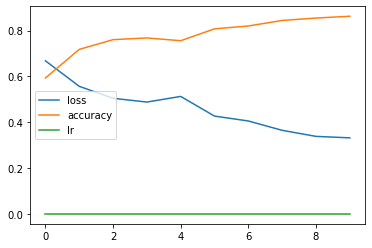

In [38]:
pd.DataFrame(cnn.history.history).plot()

In [39]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

13/13 [==============================] - 25s 2s/step - loss: 0.2699 - accuracy: 0.9075
The testing accuracy is : 90.75000286102295 %


In [41]:
preds = cnn.predict(test,verbose=1)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

13/13 [==============================] - 28s 2s/step


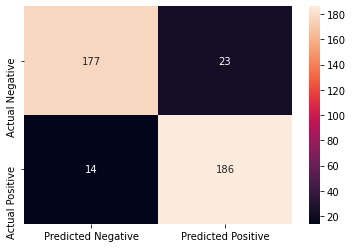

In [48]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Negative", "Actual Positive"],
columns=["Predicted Negative", "Predicted Positive"])
import seaborn as sns
sns_plot = sns.heatmap(cm,annot=True,fmt="d")
fig = sns_plot.get_figure()
fig.savefig('/Users/yimi/Desktop/Courses/UC_Davis/2021spring/STA208/208Project/batch32.png')

In [43]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        1